In [1]:
%%capture

!pip install datasets
!pip install sentence-transformers
!pip install transformers

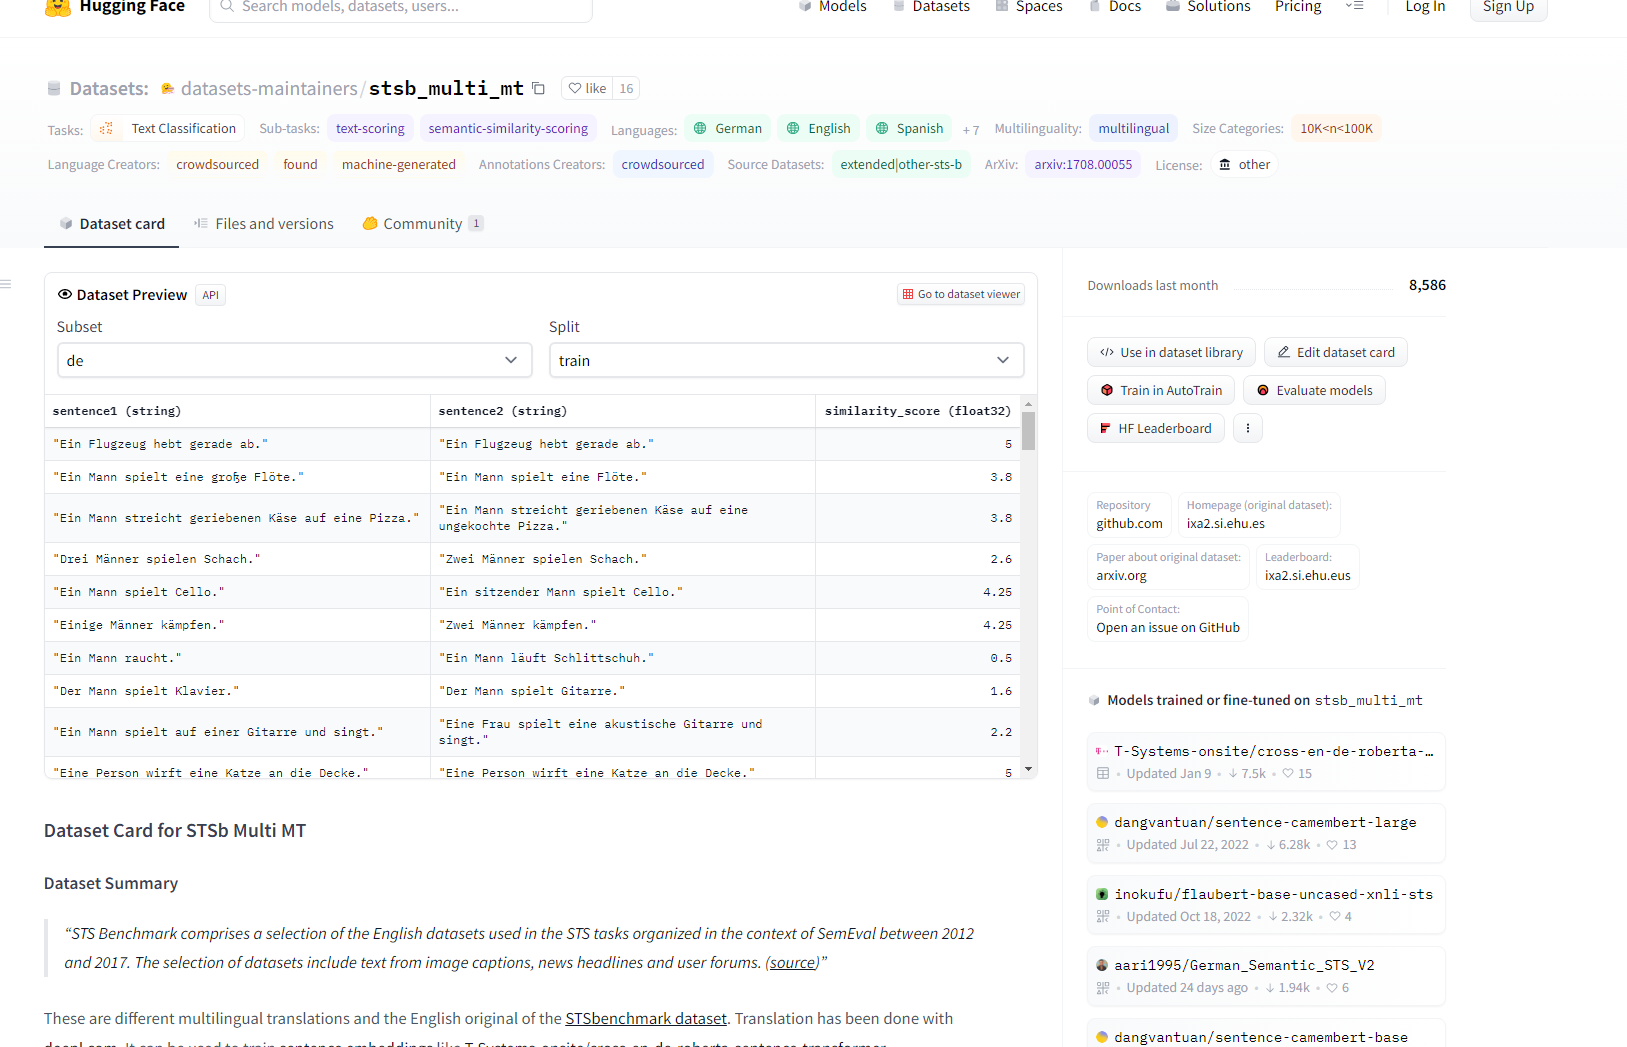

In [2]:
import torch
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset

In [3]:
# Dataset for training
dataset = load_dataset("stsb_multi_mt", name="en", split="train")
similarity = [i['similarity_score'] for i in dataset]
normalized_similarity = [i/5.0 for i in similarity]

# Dataset for test
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

# Prepare test data
sentence_1_test = [i['sentence1'] for i in test_dataset]
sentence_2_test = [i['sentence2'] for i in test_dataset]
text_cat_test = [[str(x), str(y)] for x,y in zip(sentence_1_test, sentence_2_test)]

# Set the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


In [4]:
class STSBertModel(torch.nn.Module):

    def __init__(self):

        super(STSBertModel, self).__init__()

        word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=128)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        self.sts_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    def forward(self, input_data):

        output = self.sts_model(input_data)
        
        return output

In [5]:
class DataSequence(torch.utils.data.Dataset):

    def __init__(self, dataset):

        similarity = [i['similarity_score'] for i in dataset]
        self.label = [i/5.0 for i in similarity]
        self.sentence_1 = [i['sentence1'] for i in dataset]
        self.sentence_2 = [i['sentence2'] for i in dataset]
        self.text_cat = [[str(x), str(y)] for x,y in zip(self.sentence_1, self.sentence_2)]

    def __len__(self):

        return len(self.text_cat)

    def get_batch_labels(self, idx):

        return torch.tensor(self.label[idx])

    def get_batch_texts(self, idx):

        return tokenizer(self.text_cat[idx], padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

def collate_fn(texts):

  num_texts = len(texts['input_ids'])
  features = list()
  for i in range(num_texts):
      features.append({'input_ids':texts['input_ids'][i], 'attention_mask':texts['attention_mask'][i]})
  
  return features

In [6]:
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fct = torch.nn.MSELoss(), cos_score_transformation=torch.nn.Identity()):
      
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation
        self.cos = torch.nn.CosineSimilarity(dim=1)

    def forward(self, input, label):

        embedding_1 = torch.stack([inp[0] for inp in input])
        embedding_2 = torch.stack([inp[1] for inp in input])

        output = self.cos_score_transformation(self.cos(embedding_1, embedding_2))

        return self.loss_fct(output, label.squeeze())

In [ ]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = STSBertModel()

    criterion = CosineSimilarityLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataset = DataSequence(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=bs, shuffle=True)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    best_acc = 0.0
    best_loss = 1000

    for i in range(epochs):

        total_acc_train = 0
        total_loss_train = 0.0

        for train_data, train_label in tqdm(train_dataloader):

            train_data['input_ids'] = train_data['input_ids'].to(device)
            train_data['attention_mask'] = train_data['attention_mask'].to(device)
            del train_data['token_type_ids']

            train_data = collate_fn(train_data)

            output = [model(feature)['sentence_embedding'] for feature in train_data]

            loss = criterion(output, train_label.to(device))
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f}')
        model.train()

    return model

EPOCHS = 8
LEARNING_RATE = 1e-6
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

  2%|▏         | 13/719 [05:22<4:38:52, 23.70s/it]

In [ ]:
# Function to predict test data
def predict_sts(texts):

  trained_model.to('cpu')
  trained_model.eval()
  test_input = tokenizer(texts, padding='max_length', max_length = 128, truncation=True, return_tensors="pt")
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']

  test_output = trained_model(test_input)['sentence_embedding']
  sim = torch.nn.functional.cosine_similarity(test_output[0], test_output[1], dim=0).item()

  return sim

In [ ]:
predict_sts(text_cat_test[245])